# Predicting Wealth & Poverty with SatCLIP

SatCLIP is a model that was trained on 1.5B geotagged images from the internet. It uses a contrastive learning approach to learn representations of satellite imagery. You can read more about it in the [paper](https://arxiv.org/abs/2311.17179) or check out the [GitHub repo](https://github.com/microsoft/satclip/). Here, we'll use it to extract location encodings and predict wealth and poverty in SustainBench Task 1A.

![satclip](https://raw.githubusercontent.com/microsoft/satclip/master/figures/satclip.png)

## Environment Setup

We start by setting up **SatCLIP** code and installing dependencies.

In [1]:
import warnings
warnings.filterwarnings('ignore')
print('warnings ignored')

warnings ignored


In [2]:
# install packages we need to run SatCLIP
!pip -q install --upgrade --no-cache-dir \
  "numpy==1.26.4" "scipy==1.11.4" \
  lightning rasterio torchgeo basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 184.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 266.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 401.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 214.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 382.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 375.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 248.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 400.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 253.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 279.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 356.4 MB/s eta 0:00:00
   

In [3]:
import os
import shutil

# remove directory if it exists
dirpath = os.path.join('/kaggle/working/satclip/')
if os.path.exists(dirpath) and os.path.isdir(dirpath):
    shutil.rmtree(dirpath)

# get satclip code
!git clone https://github.com/microsoft/satclip.git # Clone SatCLIP repository

Cloning into 'satclip'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 283 (delta 93), reused 87 (delta 87), pack-reused 173 (from 1)
Receiving objects: 100% (283/283), 30.77 MiB | 44.82 MiB/s, done.
Resolving deltas: 100% (121/121), done.


You should find the SatCLIP repo in the working directory now.

Chose a SatCLIP model from the list of available pretrained models [here](https://github.com/microsoft/satclip#pretrained-models). They all perform somewhat similarly. Let's download a SatCLIP using a ResNet18 vision encoder and $L=40$ Legendre polynomials in the location encoder (i.e., a high-resolution SatCLIP). Other options include using a ResNet50 vision encoder or a Vision Transformer (ViT) encoder, or using $L=10$ Legendre polynomials (i.e., a low-resolution SatCLIP).

In [4]:
# import code from satclip repo
import sys
sys.path.append('./satclip/satclip')
import torch
from load import get_satclip

# data processing
import numpy as np
import pandas as pd

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# for prediction
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split


# configure pytorch device
if torch.cuda.is_available():
    device = torch.device("cuda") # CUDA for GPUs
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Metal Performance Shaders (MPS) for macOS
else:
    device = torch.device("cpu") # Otherwise use CPUs

print(f"Using device: {device}")

# configure random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(44)

Using device: cuda


Load required packages.

## Bring in Poverty Mapping Dataset

In [5]:
def get_poverty_data(path="dhs_final_labels.csv", pred="asset_index"):
  '''
  Download and process the poverty mapping dataset from SustainBench (more info: https://www.nature.com/articles/sdata2018246)

  Parameters:
  pred = numeric; name of outcome variable to be returned, 0-indexed. Must be numeric column. 6 is 'asset_index'
  norm_y = logical; should outcome be normalized

  Return:
  coords = spatial coordinates (lon/lat)
  y = outcome variable
  '''
  df = pd.read_csv(path)
  lat = np.array(df['lat'])
  lon = np.array(df['lon'])
  coords = np.column_stack((lon, lat))
  y = np.array(df[pred]).reshape(-1)

  return torch.tensor(coords), torch.tensor(y)

print('function defined')

function defined


In [6]:
coords, y = get_poverty_data(pred="asset_index", path='/kaggle/input/dhs-labels-for-poverty-mapping-from-sustainbench/dhs_final_labels.csv')
print("Coordinates tensor:", coords)
print("Outcome variable tensor:", y)

Coordinates tensor: tensor([[ 19.8383,  40.8227],
        [ 20.0076,  40.6968],
        [ 19.9743,  40.7500],
        ...,
        [ 29.8506, -16.6606],
        [ 30.9570, -17.9143],
        [ 31.7976, -17.8591]], dtype=torch.float64)
Outcome variable tensor: tensor([ 2.4306,  2.8677,  2.9090,  ..., -1.1251,  2.2174,  0.1761],
       dtype=torch.float64)


Let's plot our data. Here we show a map of the world with our locations colored by mean temperatures.

Text(0.5, 1.0, 'Mean Asset Index')

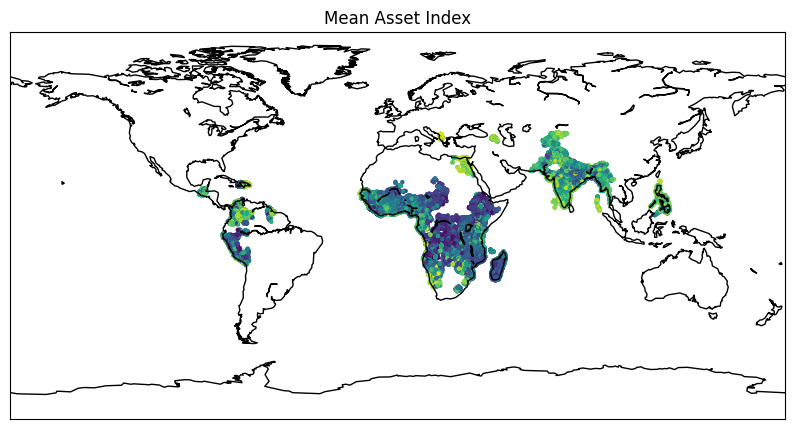

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 6))

m = Basemap(projection='cyl', resolution='c', ax=ax)
m.drawcoastlines()
ax.scatter(coords[:,0], coords[:,1], c=y, s=5)
ax.set_title('Mean Asset Index')

## Get SatCLIP Embeddings

We now want to wealth values using SatCLIP embeddings. First, we need to obtain the location embeddings for our dataset from the pretrained model.

In [8]:
from huggingface_hub import hf_hub_download
from load import get_satclip
import torch

satclip_model = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ResNet18-L40", "satclip-resnet18-l40.ckpt"),
    device=device,
)  # Only loads location encoder by default
satclip_model.eval()
with torch.no_grad():
    x = satclip_model(coords.double().to(device)).detach().cpu()

print("Shape of coordinate tensor:", coords.shape)
print("Shape of location embeddings tensor:", x.shape)

satclip-resnet18-l40.ckpt:   0%|          | 0.00/75.6M [00:00<?, ?B/s]

using pretrained moco resnet18


Downloading: "https://hf.co/torchgeo/resnet18_sentinel2_all_moco/resolve/5b8cddc9a14f3844350b7f40b85bcd32aed75918/resnet18_sentinel2_all_moco-59bfdff9.pth" to /root/.cache/torch/hub/checkpoints/resnet18_sentinel2_all_moco-59bfdff9.pth
100%|██████████| 42.8M/42.8M [00:04<00:00, 9.92MB/s]


Shape of coordinate tensor: torch.Size([117644, 2])
Shape of location embeddings tensor: torch.Size([117644, 256])


We have now collected a 256-dimensional location embedding for each latitude/longitude coordinate in our dataset. Let's merge it, convert it to a dataframe, and save it to a csv file.

In [9]:
# convert x, y, and coords from tensors in dataframes
df = pd.DataFrame(x.numpy(), columns=[f"X_{i}" for i in range(x.shape[1])])
df["asset_index"] = y.numpy()  # Ensure y is a 1D column
df["lon"] = coords[:, 0].numpy()  # Extract longitude
df["lat"] = coords[:, 1].numpy()  # Extract latitude
df.head()
df.to_csv("dhs_final_labels_with_satclip.csv", index=False)

## Prep Data for Predicting Wealth Using Regression
1. Drop any rows with missing label values
2. Split into test / validation / train datasets

In [10]:
# read back in the dataframe
df = pd.read_csv("dhs_final_labels_with_satclip.csv")

# check for NaNs
print("Number of NaNs in df: ", df.isna().sum())
# drop rows with NaNs
df = df.dropna()
# check the shape again
print("Shape of df: ", df.shape)

# create a train/val/test split of 80/10/10
from sklearn.model_selection import train_test_split

# split the data into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
# split the test set into val and test sets
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)
# check the shapes of the data
print("Shape of df_train: ", df_train.shape)
print("Shape of df_val: ", df_val.shape)
print("Shape of df_test: ", df_test.shape)

# save dfs as csvs
df_train.to_csv("df_train.csv", index=False)
df_val.to_csv("df_val.csv", index=False)
df_test.to_csv("df_test.csv", index=False)

print("files written")

Number of NaNs in df:  X_0                0
X_1                0
X_2                0
X_3                0
X_4                0
               ...  
X_254              0
X_255              0
asset_index    30708
lon                0
lat                0
Length: 259, dtype: int64
Shape of df:  (86936, 259)
Shape of df_train:  (69548, 259)
Shape of df_val:  (8694, 259)
Shape of df_test:  (8694, 259)
files written


Now split up each of the datasets into inputs and outputs.

In [11]:
# get data again
df_train = pd.read_csv("df_train.csv")
df_val = pd.read_csv("df_val.csv")
df_test = pd.read_csv("df_val.csv")

# get label y
y_train = df_train["asset_index"]
y_val = df_val["asset_index"]
y_test = df_test["asset_index"]

# get coordinates
coords_train = df_train[["lon", "lat"]]
coords_val = df_val[["lon", "lat"]]
coords_test = df_test[["lon", "lat"]]

# x is all the data in columns with names formatted like "X_1"
X_train = df_train[[col for col in df.columns if col.startswith("X_")]]
X_val = df_val[[col for col in df.columns if col.startswith("X_")]]
X_test = df_test[[col for col in df.columns if col.startswith("X_")]]

print("data separated")

data separated


## Prediction Using Regression with Ridge Model
Let's repeat the analysis we did with MOSAIKS embeddings with our SatCLIP embeddings. Start by reading in our dataset with the embeddings, removing any NA rows, and splitting it 80/10/10 train/val/test.

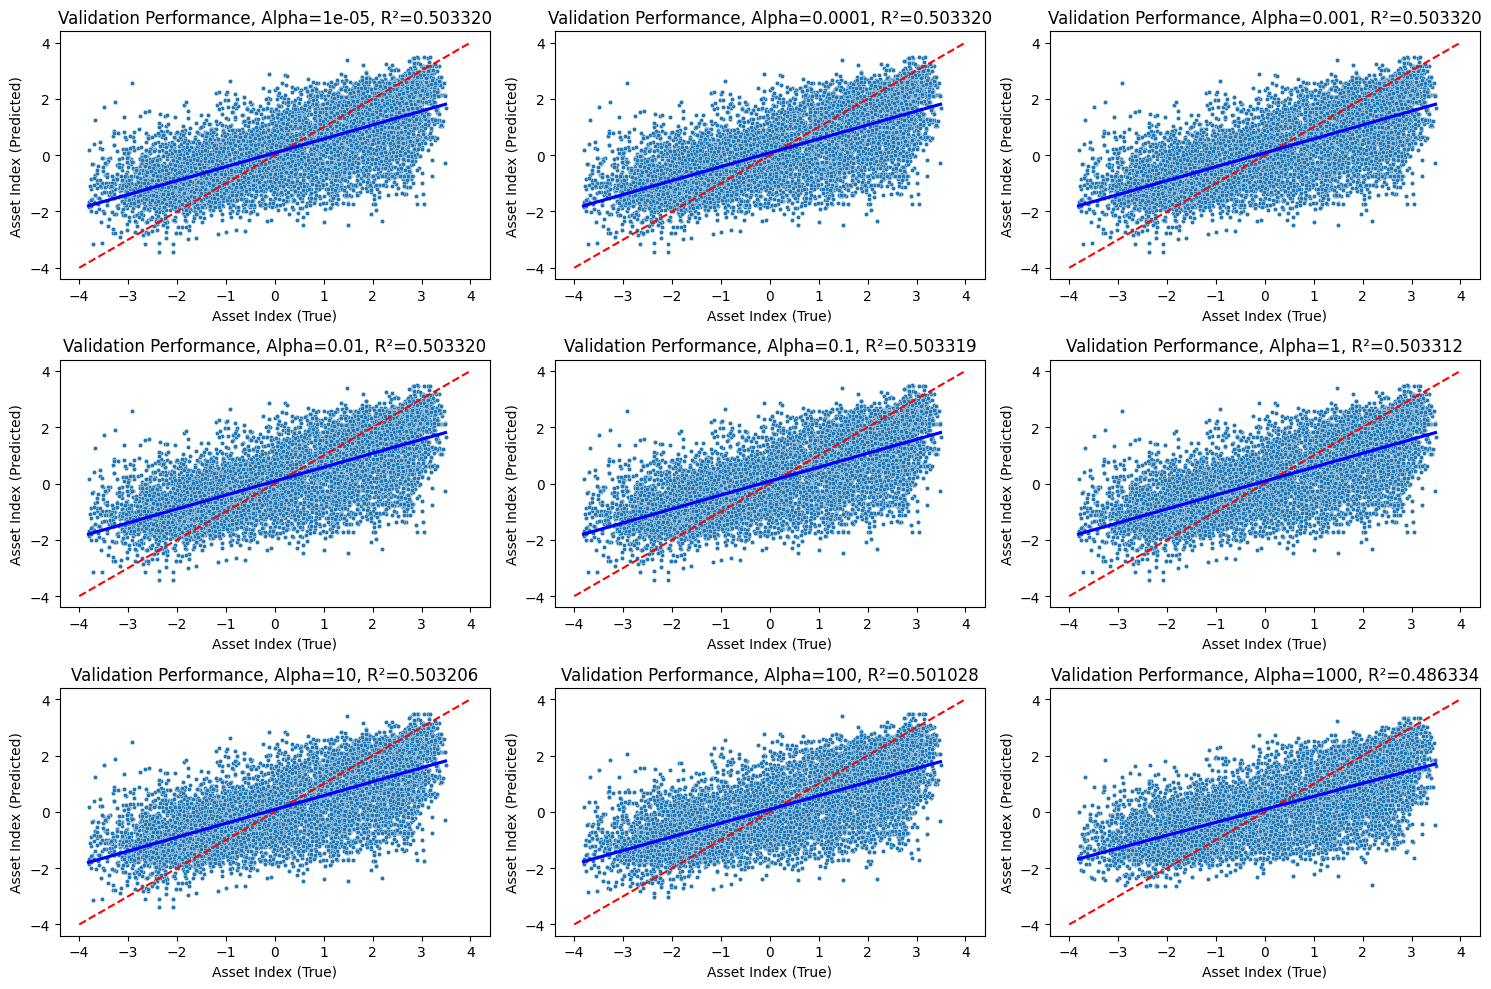

In [12]:
# Define alpha values to loop over
alpha_values = [10**i for i in range(-5, 4)]  # Corrected alpha values from 0.001 to 1000

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.ravel()

for i, alpha in enumerate(alpha_values):
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    y_pred = ridge_model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    
    # Create scatter plot using Seaborn
    sns.scatterplot(x=y_val, y=y_pred, ax=axes[i], s=10)
    axes[i].plot([-4, 4], [-4, 4], "r--")  # 45-degree line
    
    # Fit a regression line with confidence interval
    sns.regplot(x=y_val, y=y_pred, ax=axes[i], scatter=False, ci=95, line_kws={"color": "blue"})
    
    axes[i].set_title(f"Validation Performance, Alpha={alpha}, R²={r2:.6f}")
    axes[i].set_xlabel("Asset Index (True)")
    axes[i].set_ylabel("Asset Index (Predicted)")

plt.tight_layout()
plt.show()

We can see here that alpha values below 0.01 perform similarly well. Let's choose the same alpha value as MOSAIKS, alpha 0.01 to run on the test data.

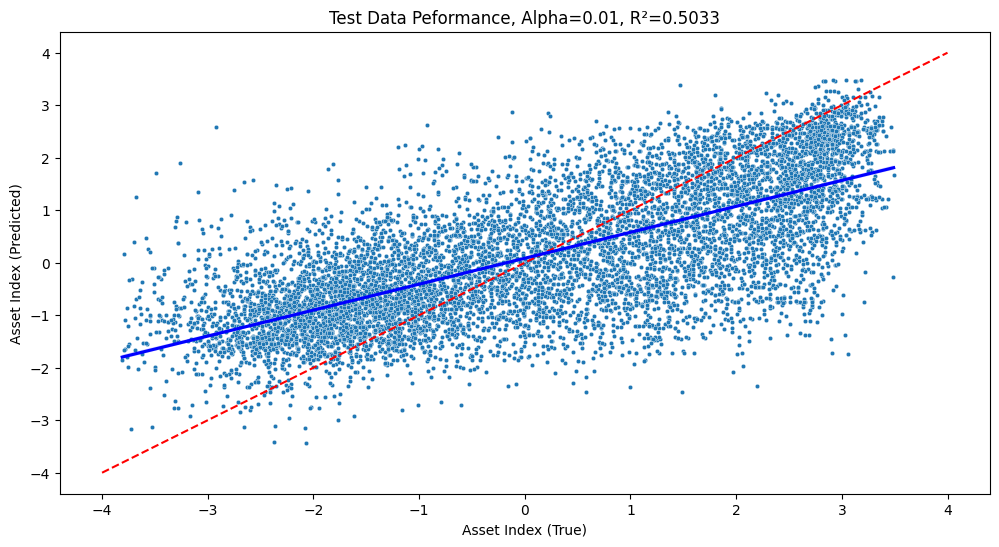

In [13]:
# Select the best alpha value from the validation data
alpha = 0.01

# Train Ridge regression model on training data
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)
coefficients = ridge_model.coef_

# Use coefficients from training for inference on test data
y_pred = X_test @ coefficients + ridge_model.intercept_
r2 = r2_score(y_test, y_pred)

# Create scatter plot using Seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred, s=10)
plt.plot([-4, 4], [-4, 4], "r--")  # 45-degree line

# Fit a regression line with confidence interval
sns.regplot(x=y_test, y=y_pred, scatter=False, ci=95, line_kws={"color": "blue"})

plt.title(f"Test Data Peformance, Alpha={alpha}, R²={r2:.4f}")
plt.xlabel("Asset Index (True)")
plt.ylabel("Asset Index (Predicted)")

plt.show()

Nice! Our final performance on the test data is slightly better than the validation data with an R-squared of 0.5075. How does this compare to MOSAIKS?

## Prediction Using a Simple MLP
Instead of just regression, we can use any prediction model to predict our outcome variable from the location embeddings. Here, let's implement a very simple MLP to predict poverty from the SatCLIP location embeddings. For a more task specific, "heavier" approach, you can also directly unfreeze the location encoder `model` above and fine-tune it.

In [14]:
# read in merged dataset
df = pd.read_csv("dhs_final_labels_with_satclip.csv")

# Convert lat/lon back to tensors
coords_train = torch.tensor(df_train[["lon", "lat"]].values, dtype=torch.float32)
coords_val = torch.tensor(df_val[["lon", "lat"]].values, dtype=torch.float32)
coords_test = torch.tensor(df_test[["lon", "lat"]].values, dtype=torch.float32)

# Convert features (X) and target (y) back to tensors
X_train = torch.tensor(df_train.filter(like="X_").values, dtype=torch.float32)
X_val = torch.tensor(df_val.filter(like="X_").values, dtype=torch.float32)
X_test = torch.tensor(df_test.filter(like="X_").values, dtype=torch.float32)

y_train = torch.tensor(df_train["asset_index"].values, dtype=torch.float32)
y_val = torch.tensor(df_val["asset_index"].values, dtype=torch.float32)
y_test = torch.tensor(df_test["asset_index"].values, dtype=torch.float32)

# Print shapes for verification
print(f"coords_train shape: {coords_train.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

coords_train shape: torch.Size([69548, 2])
X_train shape: torch.Size([69548, 256])
y_train shape: torch.Size([69548])


In [15]:
class MLP(nn.Module):
    def __init__(self, input_dim, dim_hidden, num_layers, out_dims):
        super(MLP, self).__init__()

        layers = []
        layers += [nn.Linear(input_dim, dim_hidden, bias=True), nn.ReLU()] # Input layer
        layers += [nn.Linear(dim_hidden, dim_hidden, bias=True), nn.ReLU()] * num_layers # Hidden layers
        layers += [nn.Linear(dim_hidden, out_dims, bias=True)] # Output layer

        self.features = nn.Sequential(*layers)

    def forward(self, x):
        return self.features(x)

print('model defined')

model defined


In [16]:
satclip_model

LocationEncoder(
  (posenc): SphericalHarmonics()
  (nnet): SirenNet(
    (layers): ModuleList(
      (0-1): 2 x Siren(
        (activation): Sine()
      )
    )
    (last_layer): Siren(
      (activation): Identity()
    )
  )
)

Let's set up and run the training loop.

In [17]:
# Model, loss, optimizer
pred_model = MLP(input_dim=256, dim_hidden=64, num_layers=1, out_dims=1).float().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(pred_model.parameters(), lr=0.001)

losses = []
val_losses = []
epochs = 2000
m = 50  # Evaluate every 'm' epochs

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward pass on training data
    y_pred = pred_model(X_train.float().to(device))
    loss = criterion(y_pred.reshape(-1), y_train.float().to(device))
    
    # Backward pass and update
    loss.backward()
    optimizer.step()
    
    # Track training loss
    losses.append(loss.item())

    # Evaluate on validation set every m epochs
    if (epoch + 1) % m == 0:
        pred_model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            y_val_pred = pred_model(X_val.float().to(device))
            val_loss = criterion(y_val_pred.reshape(-1), y_val.float().to(device)).item()
            val_losses.append(val_loss)
        
        print(f"Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
        pred_model.train()  # Set model back to training mode

Epoch 50, Train Loss: 1.6587, Val Loss: 1.6612
Epoch 100, Train Loss: 1.4863, Val Loss: 1.5069
Epoch 150, Train Loss: 1.4113, Val Loss: 1.4458
Epoch 200, Train Loss: 1.3625, Val Loss: 1.4042
Epoch 250, Train Loss: 1.3280, Val Loss: 1.3767
Epoch 300, Train Loss: 1.3041, Val Loss: 1.3553
Epoch 350, Train Loss: 1.2876, Val Loss: 1.3443
Epoch 400, Train Loss: 1.2777, Val Loss: 1.3359
Epoch 450, Train Loss: 1.2635, Val Loss: 1.3251
Epoch 500, Train Loss: 1.2474, Val Loss: 1.3158
Epoch 550, Train Loss: 1.2433, Val Loss: 1.3129
Epoch 600, Train Loss: 1.2249, Val Loss: 1.2984
Epoch 650, Train Loss: 1.2197, Val Loss: 1.2953
Epoch 700, Train Loss: 1.2200, Val Loss: 1.3004
Epoch 750, Train Loss: 1.2165, Val Loss: 1.2940
Epoch 800, Train Loss: 1.2073, Val Loss: 1.2885
Epoch 850, Train Loss: 1.2060, Val Loss: 1.2873
Epoch 900, Train Loss: 1.1976, Val Loss: 1.2854
Epoch 950, Train Loss: 1.1928, Val Loss: 1.2783
Epoch 1000, Train Loss: 1.1831, Val Loss: 1.2768
Epoch 1050, Train Loss: 1.1736, Val Loss

In [18]:
pred_model_path = 'pred_model_weights_hl1_lr1e-3_e2k.pth'
torch.save(pred_model.state_dict(), pred_model_path)
print("model saved to", pred_model_path)

model saved to pred_model_weights_hl1_lr1e-3_e2k.pth


Now let's make predictions on the test set!

In [19]:
with torch.no_grad():
  pred_model.eval()
  y_pred_test = pred_model(X_test.float().to(device))

# Print test loss
print(f'Test loss: {criterion(y_pred_test.reshape(-1), y_test.float().to(device)).item()}')

Test loss: 1.2276097536087036


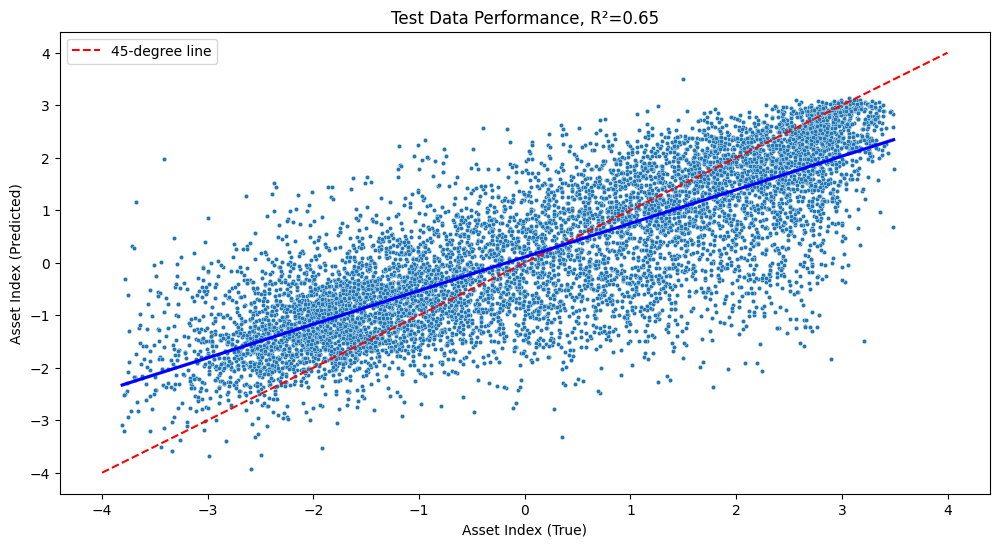

In [20]:
# Compute test predictions
with torch.no_grad():
    pred_model.eval()
    y_pred_test = pred_model(X_test.float().to(device)).cpu().numpy().flatten()

# Convert y_test to NumPy
y_test_np = y_test.cpu().numpy().flatten()

# Compute R² score
r2 = r2_score(y_test_np, y_pred_test)

# Create scatter plot using Seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test_np, y=y_pred_test, s=10)
plt.plot([-4, 4], [-4, 4], "r--", label="45-degree line")  # Perfect prediction line

# Fit a regression line with confidence interval
sns.regplot(x=y_test_np, y=y_pred_test, scatter=False, ci=95, line_kws={"color": "blue"})

# Plot settings
plt.title(f"Test Data Performance, R²={r2:.2f}")
plt.xlabel("Asset Index (True)")
plt.ylabel("Asset Index (Predicted)")
plt.legend()
plt.show()

Let's show the results on a map!

Text(0.5, 1.0, 'Predicted')

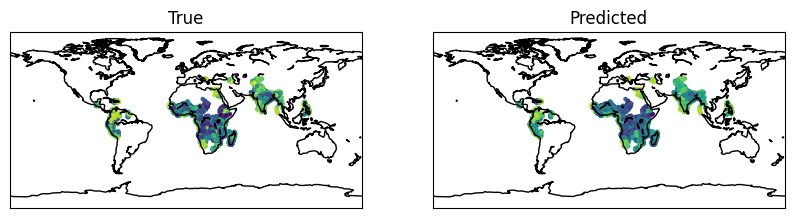

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

m = Basemap(projection='cyl', resolution='c', ax=ax[0])
m.drawcoastlines()
ax[0].scatter(coords_test[:,0], coords_test[:,1], c=y_test, s=5)
ax[0].set_title('True')

m = Basemap(projection='cyl', resolution='c', ax=ax[1])
m.drawcoastlines()
ax[1].scatter(coords_test[:,0], coords_test[:,1], c=y_pred_test.reshape(-1), s=5)
ax[1].set_title('Predicted')

## Create a Global Map of Wealth Predictions

Now that we have a model that predicts wealth given any lat/long pair, let's run it over the whole world and see what it comes up with.

In [22]:
# Latitude and longitude ranges
lat_range = np.arange(-89.9, 90, 1)  # from -90 to +90 with 0.1 intervals
lon_range = np.arange(-179.9, 180, 1)  # from -180 to +180 with 0.1 intervals

# Create a grid of latitude and longitude pairs
lat_grid, lon_grid = np.meshgrid(lat_range, lon_range)

# Reshape into a 2D array of coordinate pairs (latitude, longitude)
coords = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))

In [23]:
# read in lat/lon coordinate pairs over land at 1 deg resolution
df = pd.read_csv("/kaggle/input/dhs-labels-for-poverty-mapping-from-sustainbench/global_lat_lon_pairs.csv")
lon, lat = df['lon'].values, df['lat'].values
coords = np.column_stack([lon, lat])

# Convert to PyTorch tensor
geo_points = torch.tensor(coords, dtype=torch.float32)

print(geo_points)
print(geo_points.size())

tensor([[-179.5000,  -18.5000],
        [-179.5000,  -17.5000],
        [-179.5000,  -16.5000],
        ...,
        [ 179.5000,   69.5000],
        [ 179.5000,   70.5000],
        [ 179.5000,   71.5000]])
torch.Size([17658, 2])


Now run these locations through the pre-trained SatCLIP location encoder to get location embeddings for all of them.

In [24]:
satclip_model = get_satclip(
    hf_hub_download("microsoft/SatCLIP-ResNet18-L40", "satclip-resnet18-l40.ckpt"),
    device=device,
)  # Only loads location encoder by default
satclip_model.eval()
with torch.no_grad():
  X_global  = satclip_model(geo_points.double().to(device)).detach().cpu()

print("Shape of coordinate tensor:", coords.shape)
print("Shape of location embeddings tensor:", x.shape)

using pretrained moco resnet18
Shape of coordinate tensor: (17658, 2)
Shape of location embeddings tensor: torch.Size([117644, 256])


#### Visualize the predictions

Text(0.5, 1.0, 'Mean Asset Index')

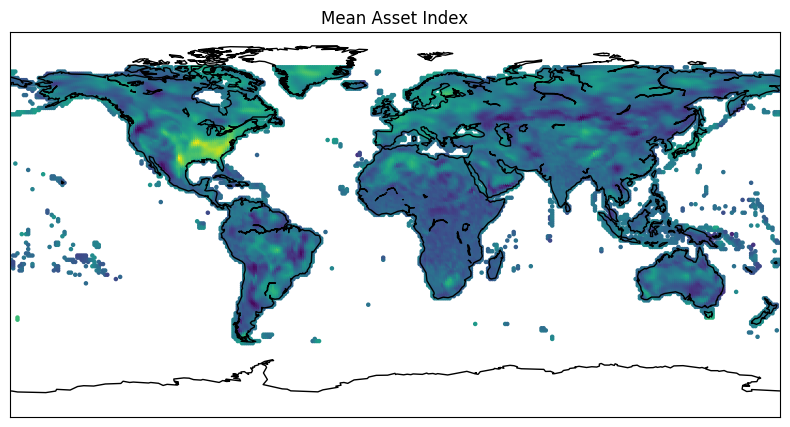

In [25]:
# reinstantiate the prediction model
pred_model = MLP(input_dim=256, dim_hidden=64, num_layers=1, out_dims=1).float().to(device)
# load the weights
pred_model_path = 'pred_model_weights_hl1_lr1e-3_e2k.pth'
pred_model.load_state_dict(torch.load(pred_model_path, weights_only=True))

# run inference on the global dataset
with torch.no_grad():
  pred_model.eval()
  y_pred_global = pred_model(X_global.float().to(device))

# plot it globally
fig, ax = plt.subplots(1, figsize=(10, 5))

m = Basemap(projection='cyl', resolution='c', ax=ax)
m.drawcoastlines()
ax.scatter(geo_points[:,0], geo_points[:,1], c=y_pred_global.cpu(), s=5)
ax.set_title('Mean Asset Index')

## Assignment

1. Given the regression results above, answer the following questions:
    - How did the MLP predictions do compared to the Ridge regression predictions? Why do you think this is?
    - How did the SatCLIP embeddings perform at predicting wealth compared with the MOSAIKS embeddings? What do you think is the reason behind that?
2. Given the gloabl prediction, how does this compare with your intuition of the global distribution of wealth and poverty? Do you think it is more, less, or equally (in)valid to use this model trained on SatCLIP embeddings and DHS clusters for a global level prediction than MOSAIKS?
3. What modifications would you need to make to SatCLIP or MOSAIKS and this model to be able to predict a CHANGE in wealth and poverty over time? 

## Bonus Assignment (big one)
Redo this wealth prediction task in a Kaggle Notebook using the [Clay model](https://clay-foundation.github.io/model/index.html). Note that you may need the imagery input from [SustainBench](https://clay-foundation.github.io/model/index.html) in order to extract embeddings for each of the points. It will not be trivial to get the development environment up and running. I'd suggest you start with trying to get this [example notebook](https://clay-foundation.github.io/model/tutorials/embeddings.html) on exploring embeddings from Clay running. Let the class know if you figure it out!

## Convert Notebook to HTML

In [1]:
# supress warnings
import warnings
warnings.filterwarnings("ignore")

# export to HTML for webpage
import os
os.system('jupyter nbconvert --to html pt3-satclip.ipynb --HTMLExporter.theme=dark')

[NbConvertApp] Converting notebook pt3-satclip.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 2138469 bytes to pt3-satclip.html


0